<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Feature Selection </h2>	


<h4> In this section, we would like you to select between 15 and 20 features to focus your model on. This will require significant explatoratory research. The first one is already implemented for you, and the next two are pre-specified.  </h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import skimage
from skimage import io
from sklearn.manifold import TSNE

In [2]:
def find_corners(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # find Harris corners
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    
    return corners

def kmeans(corners):
    k = 10
    corners = np.float32(corners)
    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(
        corners, 
        k, 
        None, 
        criteria=criteria, 
        attempts=10, 
        flags=cv2.KMEANS_PP_CENTERS
    )
    return centers.reshape((-1,1))

# points = np.random.normal(size=(100,2))
#points = np.random.randint(25,50,(100,2))
#points = np.float32(points)
#plt.scatter(points[:,0], points[:,1])

#centers = kmeans(points)
#for center in centers:
#    plt.plot(center[0], center[1], 'ro')
#plt.show()

In [3]:
def ft0(image):
    return image.size
# Returns the pixel size of the image
def ft1(image):
    return np.mean(image[:,:,0])
# Returns the average of the red-channel pictures for the images
def ft2(image):
    return np.mean(image[:,:,1])
# Returns the average of the green-channel pictures for the images
def ft3(image):
    return np.mean(image[:,:,2])
# Returns the average of the blue-channel pictures for the images
def ft4(image):
    return image.shape[1]/image.shape[0];
def ft5(image):
    corners = find_corners(image)
    return np.mean(corners[:,0] / image.shape[1])
def ft6(image):
    corners = find_corners(image)
    return np.mean(corners[:,1] / image.shape[0])
def ft7(image):
    corners = find_corners(image)
    return np.var(corners[:,0] / image.shape[1])
def ft8(image):
    corners = find_corners(image)
    return np.var(corners[:,1] / image.shape[0])
def ft9(image):
    corners = find_corners(image)
    return corners.shape[0]
def ft10(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)
def ft11(image, k):
    print(k)
    corners = find_corners(image)
    clusters = kmeans(corners)
    return clusters
# def ft5()
#Returns the aspect ratio of the image

In [4]:
# Load in data
starting_data = pd.read_hdf('starting_data.h5')

In [5]:
# For info
data_file_path = file_path = os.path.join(os.getcwd(), 'data','20_categories_training')
folders = os.listdir(data_file_path)
folders.sort()
folders = filter(lambda folder: not folder.startswith('.'), folders)
categories = [dir_name for dir_name in folders]
print(categories)

['airplanes', 'bear', 'blimp', 'comet', 'crab', 'dog', 'dolphin', 'giraffe', 'goat', 'gorilla', 'kangaroo', 'killer-whale', 'leopards', 'llama', 'penguin', 'porcupine', 'teddy-bear', 'triceratops', 'unicorn', 'zebra']


In [6]:
# Identify images that are not correctly formatted
bool_index = [len(np.shape(image))!=3 for image in starting_data['image']]
remove_index = starting_data.loc[bool_index].index.tolist()
# starting_data.drop(remove_index, inplace=True)

# mapping 1 color channel images to 3 color channels
def expand_1_channel(image):
    if len(image.shape) == 3:
        return image
    return np.repeat(np.expand_dims(image, axis=2), 3, axis=2)
starting_data['image'] = starting_data['image'].apply(expand_1_channel)

In [7]:
# Create separate df for EDA
eda_data = starting_data.copy()

Define more features above, performing any EDA research below. We expect all external sources sited, and a couple significant different graphs indicating some form of EDA. 

<h4> Graphs </h4>

In [8]:
# Exploration of data!

# Examining trends in average color channel

# Compute the average red-channel for each image
eda_data['red_average'] = pd.Series([ft1(image) for image in eda_data['image']])

# Compute the average green-channel for each image
eda_data['green_average'] = pd.Series([ft2(image) for image in eda_data['image']])
# a = starting_data.loc[0, 'image'][:,:,0]
# print(a.shape)

# Compute the average blue-channel for each image
eda_data['blue_average'] = pd.Series([ft3(image) for image in eda_data['image']])

In [9]:
# Reorganize color variable into hue column
eda_data_colored = eda_data.copy()
if not 'new_index' in eda_data_colored:
    eda_data_colored.reset_index(inplace=True)
    eda_data_colored.rename(columns={'index':'new_index'}, inplace=True)

eda_data_colored = pd.melt(eda_data_colored, id_vars=['new_index', 'image', 'label'],
                               value_vars=['red_average', 'green_average', 'blue_average'])
eda_data_colored.rename(columns={'variable':'color'}, inplace=True)

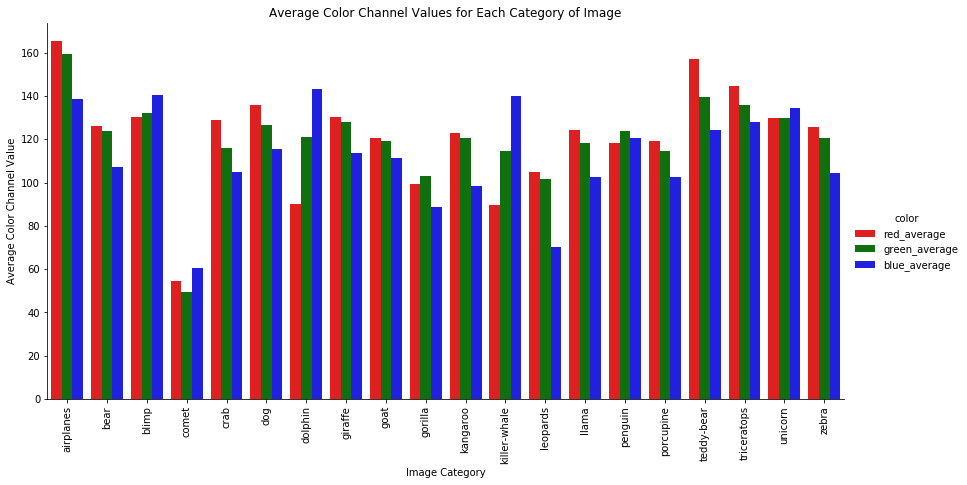

In [10]:
#sns.barplot(starting_data.groupby(['label']).mean().reset_index()['label'],
#           starting_data.groupby(['label']).mean()['red_average'])
#plt.xticks(np.arange(0,20), categories[2:], rotation=90)

plt.figure(figsize=[12,12])
sns.catplot(x='label', y='value', hue='color', data=eda_data_colored,
            kind='bar', palette=['r','g','b'], height=6, aspect=2, ci=None)
plt.xticks(np.arange(0,20), categories, rotation=90)
plt.xlabel('Image Category')
plt.ylabel('Average Color Channel Value')
plt.title('Average Color Channel Values for Each Category of Image');

In [11]:
# Exploration of data!

# Compute the aspect ratio
eda_data['aspect_ratio'] = pd.Series([ft4(image) for image in eda_data['image']])

Text(0.5,1,'Average Aspect Ratio for Each Category of Image')

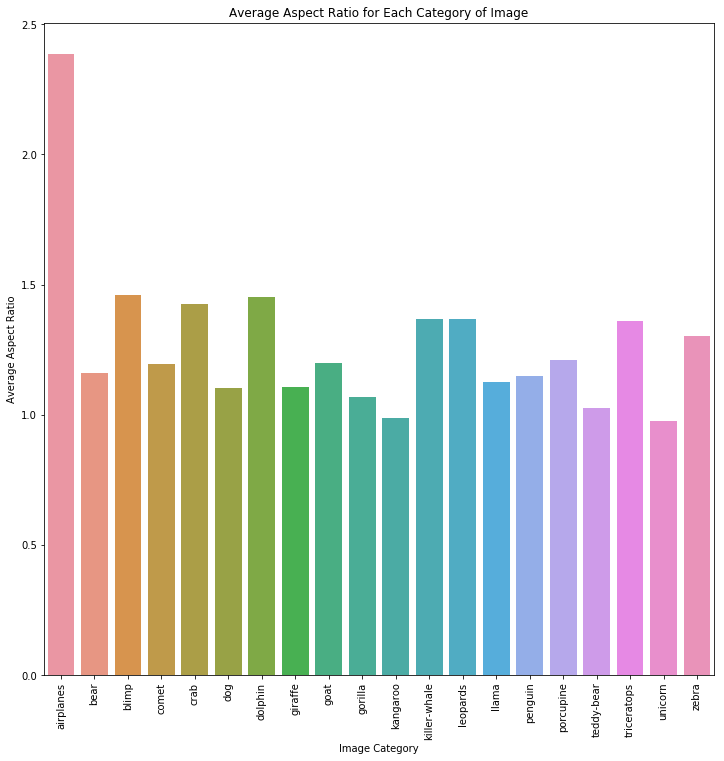

In [12]:
plt.figure(figsize=[12,12])
sns.barplot(x=eda_data.groupby(['label']).mean().reset_index()['label'],
            y=eda_data.groupby(['label']).mean()['aspect_ratio'])
plt.xlabel('Image Category')
plt.xticks(np.arange(0,20), categories, rotation=90)
plt.ylabel('Average Aspect Ratio')
plt.title('Average Aspect Ratio for Each Category of Image')

In [13]:
# Exploration of data!

# Determine the image size
eda_data['image_size'] = pd.Series([ft0(image) for image in eda_data['image']])

Text(0.5,1,'Average Image Size for Each Category of Image')

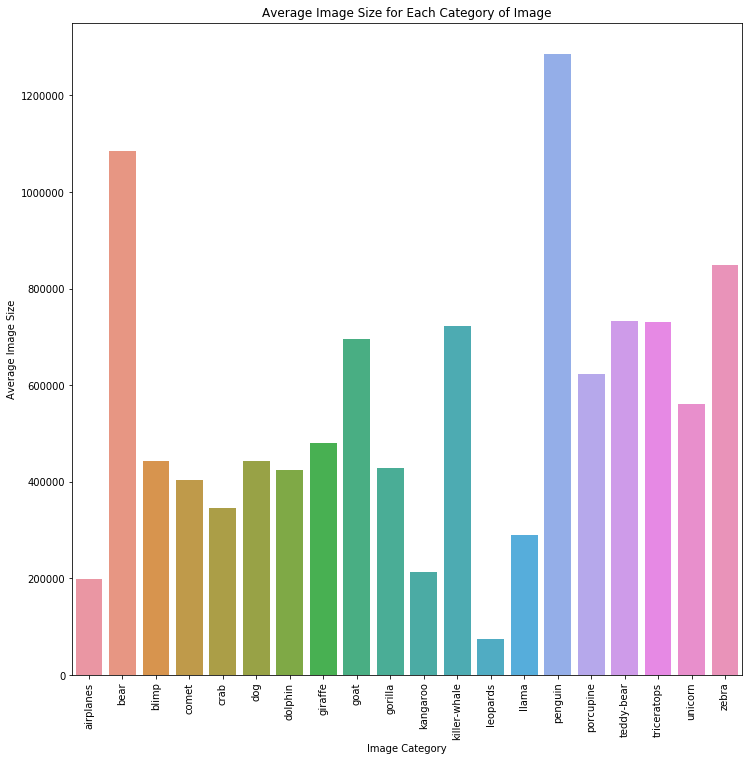

In [14]:
plt.figure(figsize=[12,12])
sns.barplot(x=eda_data.groupby(['label']).mean().reset_index()['label'],
            y=eda_data.groupby(['label']).mean()['image_size'])
plt.xticks(np.arange(0,20), categories, rotation=90)
plt.xlabel('Image Category')
plt.ylabel('Average Image Size')
plt.title('Average Image Size for Each Category of Image')

In [15]:
# Exploration of data!

# Define the corner features
# Mean normalized position of corners
eda_data['corners_avg_x'] = pd.Series([ft5(image) for image in eda_data['image']])
eda_data['corners_avg_y'] = pd.Series([ft6(image) for image in eda_data['image']])

# Variance of normalized position of corners
eda_data['corners_var_x'] = pd.Series([ft7(image) for image in eda_data['image']])
eda_data['corners_var_y'] = pd.Series([ft8(image) for image in eda_data['image']])

# Number of corners
eda_data['corners_num'] = pd.Series([ft9(image) for image in eda_data['image']])


In [16]:
# Kmeans cluster corners
eda_data['kmeans_clusters'] = pd.Series([ft11(image, k) for k, image in enumerate(eda_data['image'])])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158


error: OpenCV(3.4.4) /io/opencv/modules/core/src/kmeans.cpp:241: error: (-215:Assertion failed) N >= K in function 'kmeans'


In [ ]:
skimage.io.imshow(eda_data['image'].iloc[184])

In [ ]:
print(len(eda_data[starting_data['corners_num'] < 10]))

In [ ]:
img = eda_data['image'].iloc[184]
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

plt.figure(figsize=[12,12])
cv2.imwrite('test_image.png',img)
skimage.io.imshow(img)

In [ ]:
plt.figure(figsize=[12,12])
label_dict = {0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 
             9: 'nine', 10: 'ten', 11: 'eleven', 12: 'twelve', 13: 'thirteen', 14: 'fourteen', 15: 'fifteen', 
             16: 'sixteen', 17: 'seventeen', 18: 'eighteen', 19: 'nineteen'}
eda_data['label_string'] = eda_data['label'].map(label_dict)
sns.scatterplot(x='corners_avg_x', y='corners_avg_y', data=eda_data, hue='label_string')

In [ ]:
plt.figure(figsize=[12,12])
sns.scatterplot(x='corners_var_x', y='corners_var_y', data=eda_data, hue='label_string')

In [ ]:
plt.figure(figsize=[12,12])
sns.barplot(x=eda_data.groupby(['label']).mean().reset_index()['label'],
            y=eda_data.groupby(['label']).mean()['corners_num'])
plt.xticks(np.arange(0,20), categories, rotation=90);

<h4> Sources </h4>

<h4> DataFrame Creation </h4>

In [17]:
def feature_frame(df):
    
    df['ft1'] = pd.Series([ft1(image) for image in df['image']])
    df['ft2'] = pd.Series([ft2(image) for image in df['image']])
    df['ft3'] = pd.Series([ft3(image) for image in df['image']])
    df['ft4'] = pd.Series([ft4(image) for image in df['image']])
    df['ft5'] = pd.Series([ft5(image) for image in df['image']])
    df['ft6'] = pd.Series([ft6(image) for image in df['image']])
    df['ft7'] = pd.Series([ft7(image) for image in df['image']])
    df['ft8'] = pd.Series([ft8(image) for image in df['image']])
    df['ft9'] = pd.Series([ft9(image) for image in df['image']])
    df['ft10'] = pd.Series([ft10(image) for image in df['image']])
    
    return df
    #Returns data-frame with all the features now inside, and calculated


In [18]:
training_data = feature_frame(starting_data)
training_data.to_hdf('training_data.h5', key='df', mode='w')

/home/chriscorrea14/miniconda2/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['image', 'label']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [19]:
training_data.head()

,image,label,ft1,ft2,ft3,ft4,ft5,ft6,ft7,ft8,ft9
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,183.353871,172.750792,158.170426,2.703448,0.429701,0.488443,0.039089,0.028354,39
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,175.369108,173.519216,155.730257,2.130435,0.514157,0.509131,0.064389,0.020408,85
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,118.945767,128.029098,107.586409,2.541935,0.490441,0.461284,0.068389,0.043101,128
3,"[[[252, 251, 247], [252, 251, 247], [252, 251,...",0,169.865545,163.073735,147.204053,2.214689,0.417252,0.593149,0.068357,0.025217,75
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,169.505337,160.140544,155.502016,2.551948,0.534490,0.584889,0.054607,0.022685,40


In [20]:
feature_frame(data_from_nb1)

NameError: name 'data_from_nb1' is not defined